## Load the model

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathcal.calculator import *
from pathcal.loader import *
from pathcal.layers import * 

In [2]:
exp = load_expriment()

GPU AVAILABLE
GPU AVAILABLE
Logging results to results/20220204-143143-BSYF-LeNet


Val -1/30: 100%|███████████████████████████████████| 79/79 [00:04<00:00, 18.03it/s, loss=0.0181, top1=0.119, top5=0.488]


In [3]:
compression_rates = [4, 10, 20, 30, 40, 50]
models = [i for i in range(10)]

In [ ]:
load_model(exp, model=m, compression=c, stg="pruning")

for layer in exp.model.modules():
    weights = list(layer.named_parameters())[0][1]
    print(weights)

## Calculate actual paths

In [ ]:
paths = {}

for c in compression_rates:
    temp_path = torch.zeros((len(models), 10))
    for m in range(len(models)):
        load_model(exp, model=m, compression=c, stg="pruning")
        prev_paths = None
        prev_layer = None
        last_num = 0
        count = 0
        for layer in exp.model.modules():
            last_num += 1
        for layer in exp.model.modules():
            cur_path = []
            if isConv(layer):
                weights = list(layer.named_parameters())[0][1]
                cur_path = cal_conv_paths(prev_paths, weights)
                prev_layer = layer
                prev_paths = cur_path
            elif isLinear(layer):
                weights = list(layer.named_parameters())[0][1]
                if isConv(prev_layer):
                    prev_paths = expend_paths(prev_paths, weights)
                if last_num == count + 1:
                    cur_paths = cal_linear_paths(prev_paths, weights, threshold = 0.1)
                else:
                    cur_paths = cal_linear_paths(prev_paths, weights)
                prev_layer = layer
                prev_paths = cur_paths
                
            count += 1
        temp_path[m] = prev_paths
    paths[c] = temp_path.mean(axis=0)

In [30]:
paths

{4: tensor([3.5160e+08, 3.3880e+08, 3.8355e+08, 3.3735e+08, 3.7758e+08, 3.0708e+08,
         3.3590e+08, 3.6800e+08, 3.6267e+08, 3.7735e+08]),
 10: tensor([46616928., 44782984., 49250704., 44405612., 50465068., 39882932.,
         44328232., 48172872., 49055112., 49531704.]),
 20: tensor([6795892.0000, 6696438.0000, 7862873.5000, 6882973.0000, 8136854.5000,
         6516948.5000, 7044375.0000, 7748303.0000, 8010454.5000, 8093859.0000]),
 30: tensor([1305178.2500, 1295777.0000, 1454161.2500, 1365328.7500, 1461250.5000,
         1257456.0000, 1424468.7500, 1430127.6250, 1514544.6250, 1490930.0000]),
 40: tensor([238081.5000, 247032.7969, 266819.9062, 259180.0938, 263136.5938,
         228665.2969, 245728.4062, 262217.6875, 264883.3125, 269867.4062]),
 50: tensor([32933.8984, 34228.8984, 33803.6992, 36666.1992, 35372.3008, 33040.8008,
         34048.3984, 34731.1992, 33419.3984, 34839.8984])}

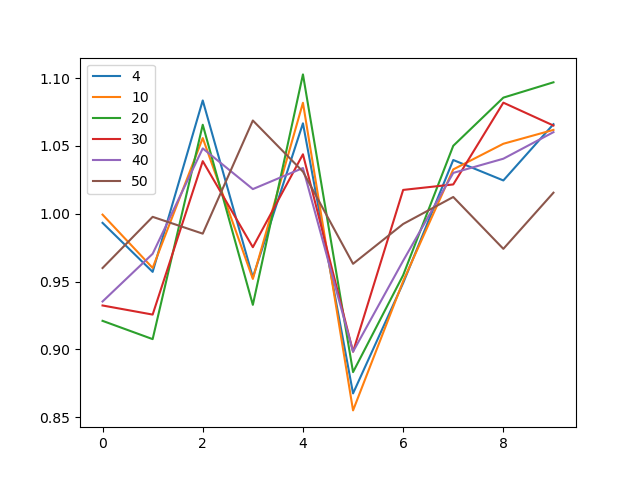

In [31]:
plt.figure()
classes = [i for i in range(10)]
for key, value in paths.items():
    ret = (value/value.mean())
    plt.plot(classes, ret.cpu().numpy(), label=key)
plt.legend()
#plt.yscale('log')

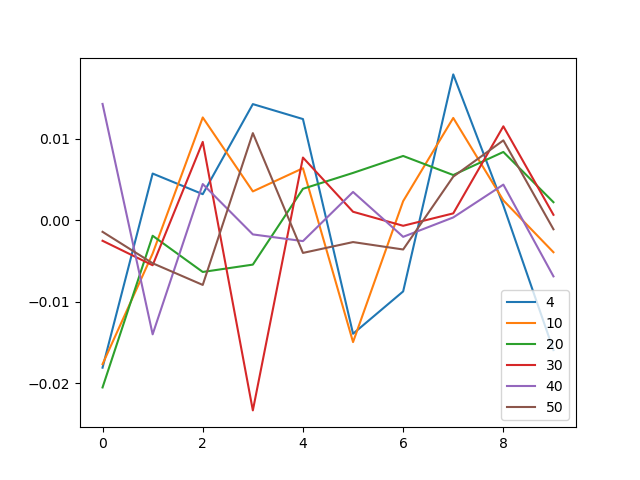

In [15]:
plt.figure()
classes = [i for i in range(10)]
for key, value in paths.items():
    ret = (value-value.mean())/value
    plt.plot(classes, ret.cpu().numpy(), label=key)
plt.legend()